In [1]:

import torch
from torch.utils.data import Dataset, DataLoader
import datasets
import pandas as pd
import torch
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import Dataset, DataLoader


torch.manual_seed(0)
print(torch.backends.mps.is_available())
mps_device = torch.device("mps")

dataset_hf = datasets.load_from_disk("./dataset") 
print(dataset_hf['train']['pixel_values'][0])
print(dataset_hf['train']['label'][0])

/Users/shayanriyaz/miniconda3/envs/TumorDetection/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
data/mri_data_seg/images/train/mri_mening_img318.png
data/mri_data_seg/masks/train/mri_mening_mask318.png


In [ ]:


# Global constants
IMAGE_SIZE = 224
BATCH_SIZE = 32

def read_files(image_path, mask=False):
    """
    Read an image file from the specified path and process it.

    Args:
        image_path (str): Path to the image file.
        mask (bool): If True, process the file as a mask (grayscale);
                     if False, process as an RGB image.

    Returns:
        torch.Tensor: The processed image tensor.
                      For non-masks: shape [3, IMAGE_SIZE, IMAGE_SIZE] (float in [0,1]).
                      For masks: shape [1, IMAGE_SIZE, IMAGE_SIZE] (normalized then cast to int32).
    """
    if mask:
        # Read image as grayscale (1 channel)
        image = decode_image(image_path, mode=ImageReadMode.GRAY)  # shape: [1, H, W]
        # Resize using nearest neighbor interpolation to preserve discrete mask values
        image = resize(image, [IMAGE_SIZE, IMAGE_SIZE], interpolation=InterpolationMode.NEAREST)
        # Normalize to [0, 1] and cast to int32 (mask values will typically be 0 or 1)
        image = image.float() / 255.0
        image = image.to(torch.int32)
    else:
        # Read image as RGB (3 channels)
        image = decode_image(image_path, mode=ImageReadMode.RGB)  # shape: [3, H, W]
        # Resize using bilinear interpolation
        image = resize(image, [IMAGE_SIZE, IMAGE_SIZE], interpolation=InterpolationMode.BILINEAR)
        # Normalize to [0, 1]
        image = image.float() / 255.0
    return image

def load_data(image_path, mask_path):
    """
    Load a single sample consisting of an image and its corresponding mask.

    Args:
        image_path (str): Path to the image file.
        mask_path (str): Path to the mask file.

    Returns:
        dict: A dictionary with keys:
              - "pixel_values": a tensor of shape [3, IMAGE_SIZE, IMAGE_SIZE]
              - "labels": a tensor of shape [IMAGE_SIZE, IMAGE_SIZE] (after squeezing the channel dimension)
    """
    image = read_files(image_path, mask=False)
    mask = read_files(mask_path, mask=True)
    mask = mask.squeeze(0)  # Remove the singleton channel dimension from the mask
    return {"pixel_values": image, "labels": mask}

class SegmentationDataset(Dataset):
    def __init__(self, image_list, mask_list):
        """
        Custom Dataset for image segmentation.

        Args:
            image_list (list): List of paths to image files.
            mask_list (list): List of paths to mask files.
        """
        self.image_list = image_list
        self.mask_list = mask_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        sample = load_data(image_path, mask_path)
        return sample

def data_gen(image_list, mask_list, split='train'):
    """
    Generate a PyTorch DataLoader for the segmentation dataset.

    Args:
        image_list (list): List of paths to image files.
        mask_list (list): List of paths to mask files.
        split (str): Split identifier, e.g., 'train' or 'test'. If 'train', the data is shuffled.

    Returns:
        DataLoader: A PyTorch DataLoader for the segmentation dataset.
    """
    dataset = SegmentationDataset(image_list, mask_list)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=(split == 'train'),
        num_workers=0,    # Set >0 for multi-process loading if desired
        pin_memory=True,
        drop_last=False
    )
    return dataloader


In [3]:

# Generate TensorFlow datasets for training, validation, and testing
train_ds = data_gen(dataset_hf['train']['pixel_values'], dataset_hf['train']['label'])

batch = next(iter(train_ds))
print("Batch keys:", batch.keys())
print("Pixel values shape (batch):", batch["pixel_values"].shape)
print("Labels shape (batch):", batch["labels"].shape)

dataset = SegmentationDataset(dataset_hf['train']['pixel_values'], dataset_hf['train']['label'])
sample = dataset[0]
print("Single sample pixel values shape:", sample["pixel_values"].shape)
print("Single sample labels shape:", sample["labels"].shape)

# # For validation dataset, use the last 100 samples
val_ds = data_gen(dataset_hf['validation']['pixel_values'],dataset_hf['validation']['label'])

# # Generate a test dataset with the first 200 samples
test_ds = data_gen(dataset_hf['test']['pixel_values'],dataset_hf['test']['label'])


Batch keys: dict_keys(['pixel_values', 'labels'])
Pixel values shape (batch): torch.Size([32, 3, 224, 224])
Labels shape (batch): torch.Size([32, 224, 224])
Single sample pixel values shape: torch.Size([3, 224, 224])
Single sample labels shape: torch.Size([224, 224])


0.9254902 0.0 1 0


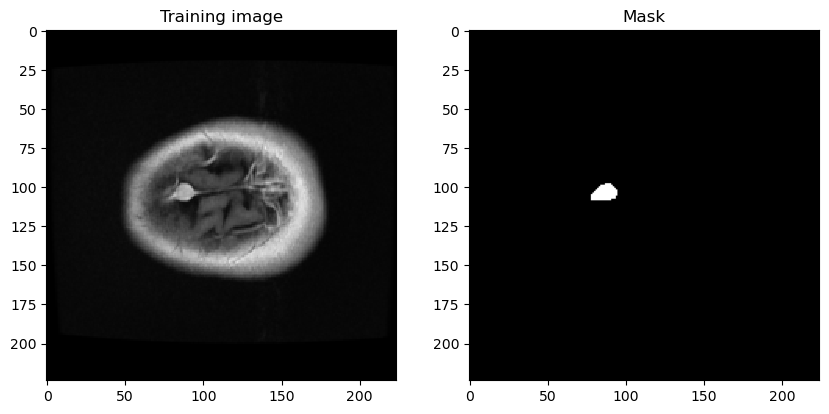

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Create a DataFrame from the first batch of the training dataset for inspection
check_data = pd.DataFrame(train_ds, columns=['pixel_values', 'labels'])

# Extract an example image and mask for inspection
im = check_data['pixel_values'][0][0]  # Check image
mask = check_data['labels'][0][0]  # Check mask

# Convert TensorFlow tensors to NumPy arrays
npimg = im.numpy()
npmask = mask.numpy()

# Print the maximum and minimum values of image and mask to check their value ranges
print(npimg.max(), npimg.min(), npmask.max(), npmask.min())

# Create a figure for visualization
fig = plt.figure(figsize=(10, 10))

# Add subplots for image and mask visualization
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# Display the image in the first subplot
ax1.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
ax1.set_title('Training image')

# Display the mask in the second subplot
ax2.imshow(npmask, cmap='gray')
ax2.set_title('Mask')

plt.show()


In [5]:
id2label = {
    0:  'bg',
    1:  'tumor',
}
label2id = {"background": 0, "tumor": 1}
n_classes = len(id2label)
n_classes

2

In [14]:
import torch
from transformers import SegformerForSemanticSegmentation, get_linear_schedule_with_warmup
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torch.nn import CrossEntropyLoss
from tqdm import trange
import torch.nn.functional as F
# ---------------------------------------------------------------------
# Define model parameters (make sure these are defined appropriately)
n_classes = 2  # for example; update to your number of classes
id2label = {0: "background", 1: "tumor"}
label2id = {"background": 0, "tumor": 1}

# Define the model checkpoint to use for semantic segmentation.
# You can choose from:
#   - nvidia/mit-b0
#   - nvidia/segformer-b0-finetuned-ade-512-512
#   - nvidia/segformer-b1-finetuned-ade-512-512
#   - nvidia/segformer-b3-finetuned-ade-512-512
#   - nvidia/segformer-b4-finetuned-ade-512-512
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
num_labels = n_classes

# Load the Segformer model for semantic segmentation
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,  # mapping from label indices to label names
    label2id=label2id,  # mapping from label names to label indices
    ignore_mismatched_sizes=True,  # allows loading even if some dimensions differ
)

# ---------------------------------------------------------------------
# Set hyperparameters for training
batch_size = 2
num_epochs = 2
learning_rate = 6e-5
weight_decay_rate = 0.01
num_train_steps = 10  # Set this based on your dataset size and batch size

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)



import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        """
        DiceLoss for multi-class segmentation.
        
        Args:
            smooth (float): Smoothing constant to avoid division by zero.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, logits, targets):
        """
        Compute Dice Loss.
        
        Args:
            logits (torch.Tensor): Raw model outputs with shape [N, C, H, W].
            targets (torch.Tensor): Ground truth masks with shape [N, H, W] containing class indices.
        
        Returns:
            torch.Tensor: The average Dice loss over the batch.
        """
        num_classes = logits.shape[1]
        # Convert targets to one-hot format with shape [N, C, H, W]
        targets_one_hot = torch.zeros_like(logits)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        
        # Apply softmax to get class probabilities
        probs = torch.softmax(logits, dim=1)
        
        # Flatten spatial dimensions: use .reshape() instead of .view()
        probs_flat = probs.contiguous().reshape(probs.size(0), num_classes, -1)
        targets_flat = targets_one_hot.contiguous().reshape(targets_one_hot.size(0), num_classes, -1)
        
        # Compute intersection and union per class for each sample
        intersection = (probs_flat * targets_flat).sum(dim=2)
        union = probs_flat.sum(dim=2) + targets_flat.sum(dim=2)
        
        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score
        
        return dice_loss.mean()
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,         # adjust if you wish to use warmup steps
#     num_training_steps=num_train_steps
# )

# ---------------------------------------------------------------------
# Set device: using the Apple MPS device if available (otherwise CPU)
mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
mps_device = torch.device("cpu")
model.to(mps_device)



Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

Training:  50%|█████     | 1/2 [00:58<00:58, 58.01s/it]

Epoch 1/2 - Loss: 0.5943


Training: 100%|██████████| 2/2 [02:01<00:00, 60.80s/it]

Epoch 2/2 - Loss: 0.5669


In [ ]:
import numpy as np
import torch

test1 = torch.rand((32,2,224,224))
test1.long().shape

In [43]:
import cv2

# Import necessary libraries for visualization and callbacks
from IPython.display import clear_output
from random import randrange

# Define a function to create a mask from predicted probabilities
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, axis=1)
    pred_mask = torch.unsqueeze(pred_mask, -1)
    return pred_mask[0]

# Define a function to calculate the mean Intersection over Union (IoU)
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_mean_iou(y_true, y_pred):
    class_iou = []
    for i in range(1, np.max(y_true) + 1):
        y_true_i = (y_true == i)
        y_pred_i = (y_pred == i)
        class_iou.append(calculate_iou(y_true_i, y_pred_i))
    mean_iou = np.mean(class_iou)
    return mean_iou

# Define a function to show predictions and evaluation metrics
def show_predictions(dataset=None, num=1):
    if dataset:
        print(dataset)
        for sample in dataset:
            # Extract images and masks from the sample
            images, masks = sample["pixel_values"], sample["labels"]
            masks = torch.unsqueeze(masks, -1)

            # Make predictions using the trained model
            with torch.no_grad():
                outputs = model(pixel_values=images)
                pred_masks = outputs.logits
            images = images.permute(0, 2, 3, 1)

            # Create binary masks
            pred_m = create_mask(pred_masks)

            # Convert masks to NumPy arrays
            mask_ar = np.array(masks[0]).astype('float32')

            pred_m = np.array(pred_m).astype('float32')
            # print (mask_ar.shape, pred_m.shape )

            # Resize masks to the same dimensions
            mask_ar = cv2.resize(mask_ar, dsize=(pred_m.shape[0], pred_m.shape[1]), interpolation=cv2.INTER_CUBIC)
            pred_ar = cv2.resize(pred_m, dsize=(pred_m.shape[0], pred_m.shape[1]), interpolation=cv2.INTER_CUBIC)

            mask_ar = np.round(mask_ar).astype(int)
            pred_ar = np.round(pred_ar).astype(int)
            # Print mask shapes and mean IoU score
            # print(mask_ar.shape, pred_ar.shape)

            print("mean IOU score", calculate_mean_iou(pred_ar, mask_ar))

            # Display images, predicted masks, and ground truth masks
            plt.figure(figsize=(12, 12))
            plt.subplot(1, 3, 1)
            plt.axis('off')
            plt.imshow(images[0])
            plt.title('Image')
            plt.subplot(1, 3, 2)
            plt.axis('off')
            plt.imshow(pred_m)
            plt.title("Pred")
            plt.subplot(1, 3, 3)
            plt.axis('off')
            plt.imshow(masks[0])
            plt.title("Ground truth")

            plt.show()

# Define a custom callback for displaying predictions during training
class Callback:
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset
    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

# # Example: A simple callback that prints the loss at the end of each epoch
class PrintLossCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))
        # print(f"Epoch {epoch} ended with loss: {logs.get('loss'):.4f}" if logs else f"Epoch {epoch} ended.")




mean IOU score 0.17647058823529413


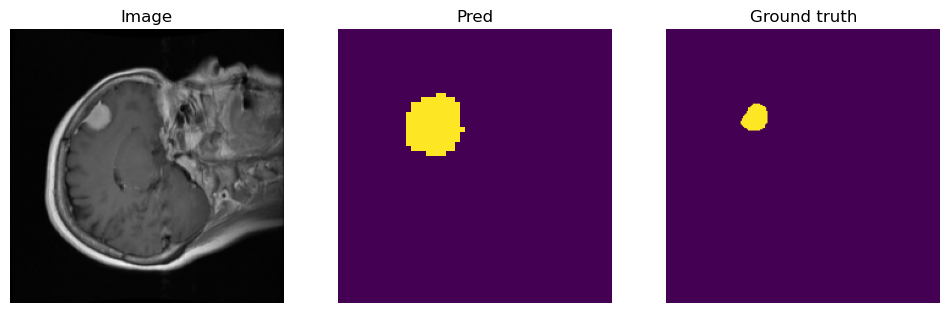

mean IOU score 0.7928571428571428


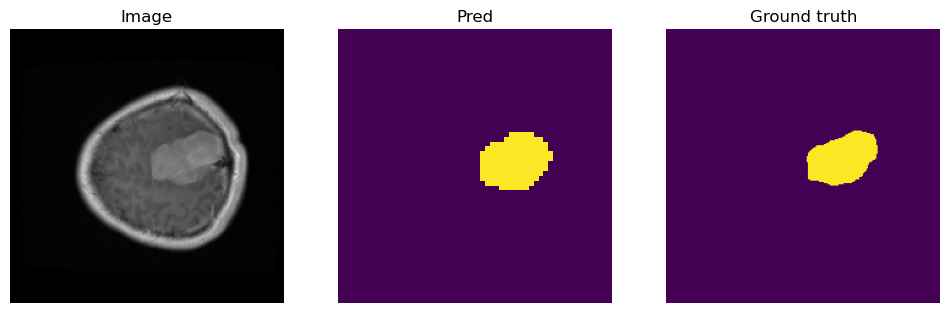

mean IOU score 0.11627906976744186


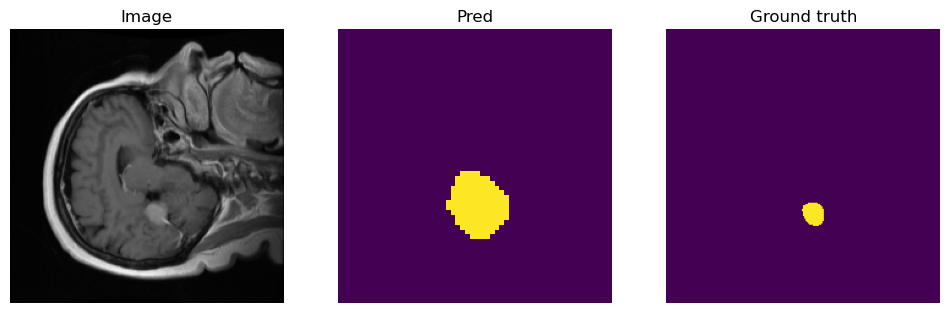

mean IOU score 0.49242424242424243


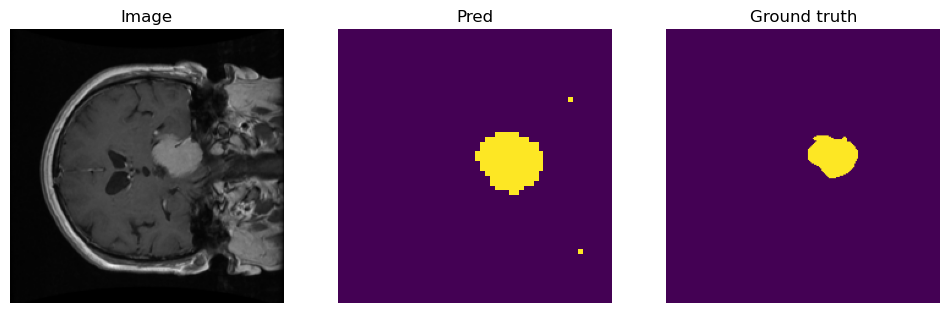

mean IOU score 0.22916666666666666


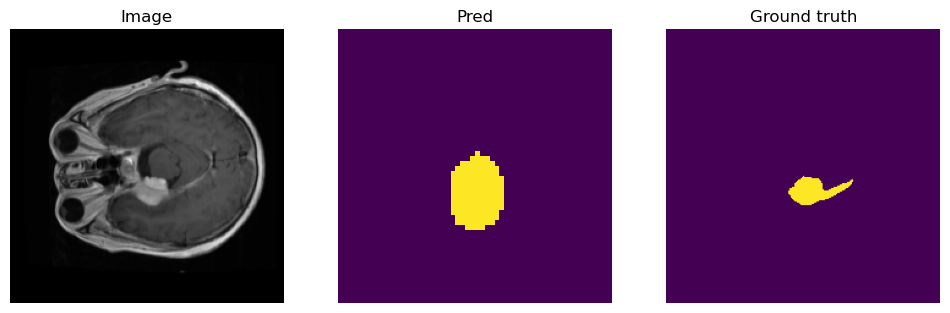

mean IOU score 0.6131386861313869


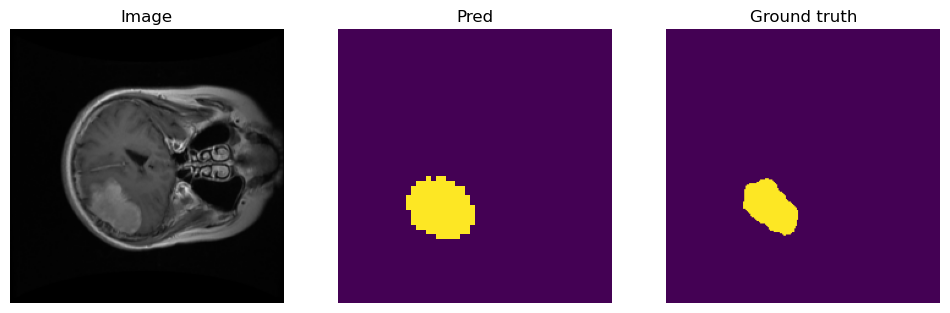

mean IOU score 0.45263157894736844


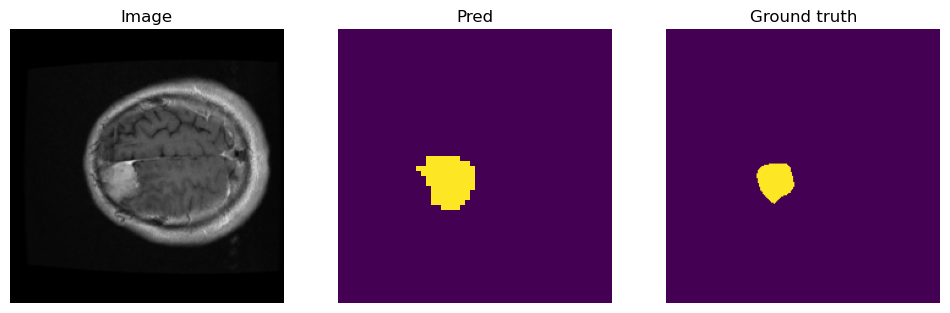

mean IOU score 0.5813953488372093


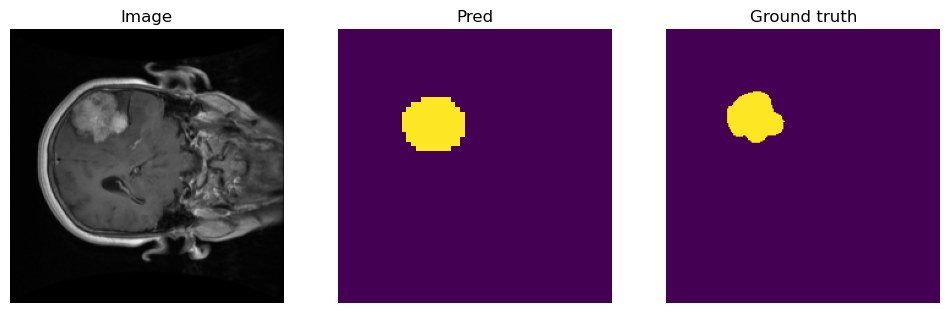

mean IOU score 0.48344370860927155


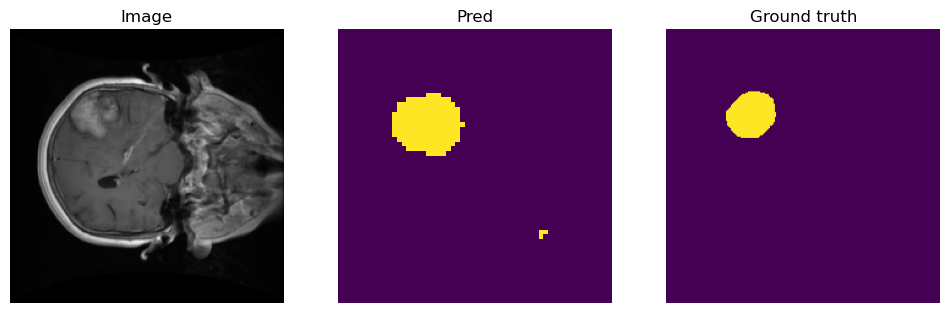

mean IOU score 0.7659574468085106


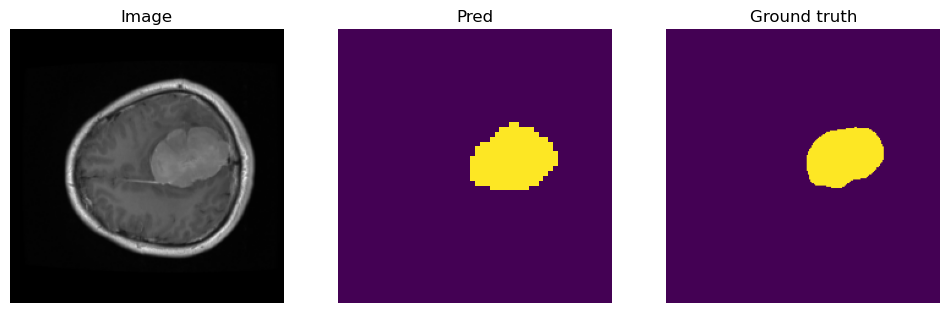

mean IOU score 0.3333333333333333


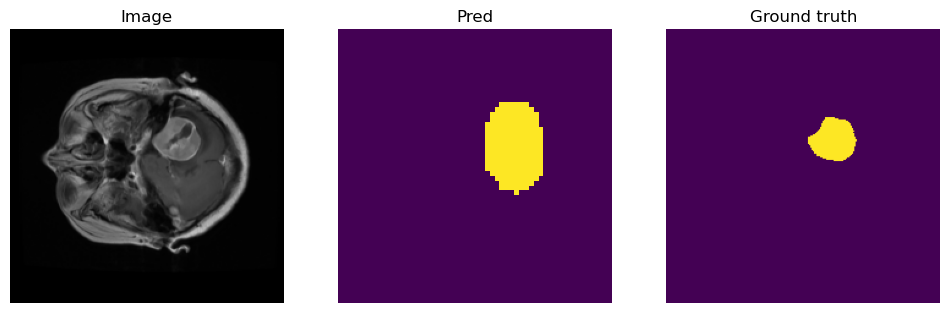

mean IOU score 0.689119170984456


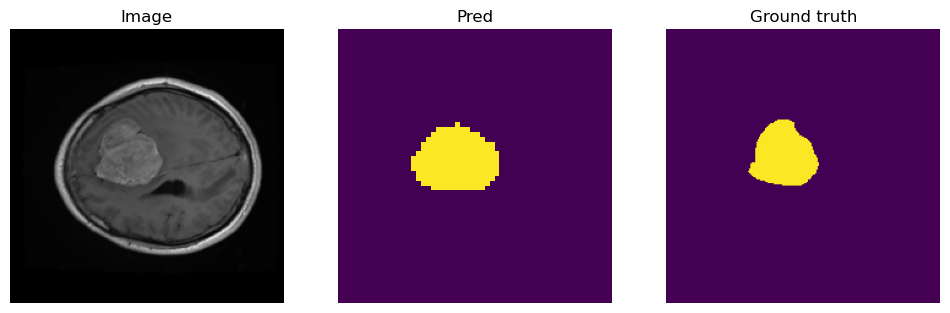

mean IOU score 0.3880597014925373


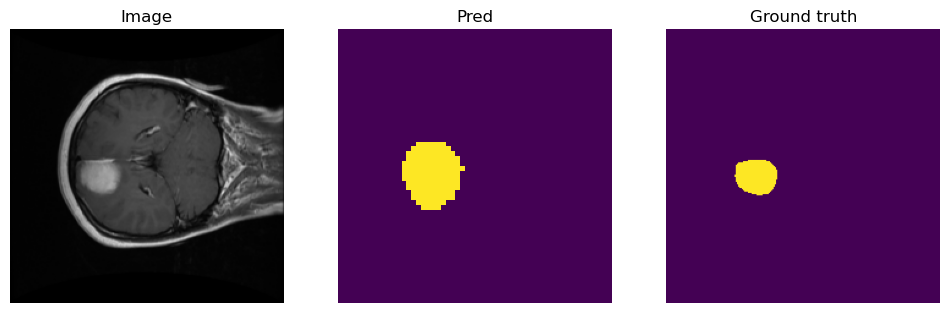


Sample Prediction after epoch 2



In [44]:
# In your training loop:
callbacks = [PrintLossCallback(dataset=train_ds)]
image_size = 224
optimizer = Adam(model.parameters(),lr = learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dice_loss_fn = DiceLoss(smooth=1.0)
for epoch in trange(num_epochs,desc="Training"):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for cb in callbacks:
        cb.on_epoch_begin(epoch)
    for batch_idx, batch in enumerate(train_ds):
        for cb in callbacks:
            cb.on_batch_begin(batch_idx)

        # Move batch data to the appropriate device
        pixel_values = batch["pixel_values"].to(mps_device)
        labels = batch["labels"].to(mps_device).long()
        optimizer.zero_grad()  # Clear the gradients
        # Forward pass; when labels are passed, many HF models return a loss in addition to outputs.
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits.contiguous()
        H_out, W_out = logits.shape[2], logits.shape[3]
        # Downsample labels from [N, 224, 224] to [N, H_out, W_out]
        labels_downsampled = F.interpolate(labels.unsqueeze(1).float(), size=(H_out, W_out), mode='nearest')
        labels_downsampled = labels_downsampled.squeeze(1).clone().long().contiguous()
        # Compute Dice Loss using logits (float) and downsampled labels (long)
        loss = dice_loss_fn(logits, labels_downsampled)
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        scheduler.step()  # Update learning rate if using a scheduler
        for cb in callbacks:
            cb.on_batch_end(batch_idx, logs={"loss": loss.item()})

    average_loss = running_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f}")

    
avg_loss = running_loss / len(train_ds)
for cb in callbacks:
    cb.on_epoch_end(epoch, logs={"loss": avg_loss})
